<a href="https://colab.research.google.com/github/dsiervo/topnews/blob/all_categories/Other_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install simpletransformers
!pip install simpletransformers
!pip install ktrain

     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 204kB 14.5MB/s 
     |████████████████████████████████| 450kB 14.1MB/s 
     |████████████████████████████████| 870kB 31.0MB/s 
     |████████████████████████████████| 1.0MB 41.1MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=75b3e6c3aab9b9447740b11fe12be035ad8399ed8ff56f21b4be4b74758bb410
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=1f6139599a21e41921e8789b93e6efc7921a5eecb7dbc9be25859c59f2378b50
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built seqeval sacremoses
     |████████████████████████████████| 92kB 4.5MB/s 
     |████████████████████████████████| 1.0MB 17.3MB/s 
     |████████████████████████████████| 245kB

In [2]:
from simpletransformers.classification import ClassificationModel
import tensorflow as tf
import pandas as pd
import ktrain
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
import cufflinks as cf
from sklearn.metrics import accuracy_score

using Keras version: 2.2.4-tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data exploration and cleaning

In [0]:
path = '/content/drive/My Drive/News_Category_Dataset_v2.json'

df_ = pd.read_json(path, lines=True)

In [5]:
df_['date'].dt.year.astype(str)

0         2018
1         2018
2         2018
3         2018
4         2018
          ... 
200848    2012
200849    2012
200850    2012
200851    2012
200852    2012
Name: date, Length: 200853, dtype: object

In [18]:
#df_['text'] = df_['date'].dt.year.astype(str)+' '+df_['authors']+' '+df_['headline'] +' '+ df_['short_description']
df_['text'] = df_['headline'] +' '+ df_['short_description']

df = df_.drop(['link', 'date', 'headline', 'short_description', 'authors'], axis=1)

df.head()

,category,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [0]:
cat_count = df['category'].value_counts()

In [0]:
culture = ['ARTS & CULTURE', 'ARTS', 'CULTURE & ARTS']
worldpost = ['WORLDPOST', 'THE WORLDPOST']
parents = ['PARENTING', 'PARENTS']

#df['category'][df['category'].isin(culture)] = "CULTURE"
#df['category'][df['category'].isin(worldpost)] = "WORLDPOST"
#df['category'][df['category'].isin(parents)] = "PARENTS"

In [0]:
cats = df.category.unique()
def cat_to_num(lab):
  return np.where(cats == lab)[0][0]

df['label'] = df['category'].apply(cat_to_num)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['label'], test_size=0.3)


## Feature engineering and downloading pretrained NBSVM model


In [33]:
(x_train, y_train), (x_test, y_test), preproc = ktrain.text.texts_from_array(
                                                            x_train=X_train.to_list(), y_train=Y_train.to_list(),
                                                            x_test=X_test.to_list(), y_test=Y_test.to_list(),
                                                            class_names=list(cats),
                                                            preprocess_mode='standard',
                                                            maxlen=350, 
                                                            max_features=35000,
                                                            ngram_range=3)

language: en
Word Counts: 98322
Nrows: 140597
140597 train sequences
Average train sequence length: 28
Adding 3-gram features
max_features changed to 4087571 with addition of ngrams
Average train sequence length with ngrams: 83
x_train shape: (140597,350)
y_train shape: (140597,41)
60256 test sequences
Average test sequence length: 28
Average test sequence length with ngrams: 59
x_test shape: (60256,350)
y_test shape: (60256,41)


## Model creation and training

In [34]:
tf.device('/device:GPU:0')
model = ktrain.text.text_classifier('nbsvm', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), batch_size=6,
                             workers=-1, use_multiprocessing = True)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-100000
rows: 100001-110000
rows: 110001-120000
rows: 120001-130000
rows: 130001-140000
rows: 140001-140597
computing log-count ratios...
done.


In [13]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 140597 samples
Epoch 1/1024
  9432/140597 [=>............................] - ETA: 1:56 - loss: 3.1920 - acc: 0.3559

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


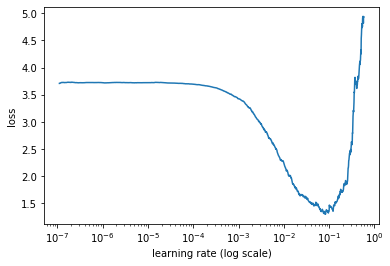

In [14]:
learner.lr_plot()

In [37]:
learner.autofit(0.001, 2)



begin training using triangular learning rate policy with max lr of 0.001...
Train on 140597 samples
Epoch 1/2
140597/140597 [==============================] - 254s 2ms/sample - loss: 0.5619 - acc: 0.8721
Epoch 2/2
140597/140597 [==============================] - 254s 2ms/sample - loss: 0.4983 - acc: 0.8880


In [39]:
learner.validate(val_data=(x_test, y_test), class_names=list(cats))

                precision    recall  f1-score   support

         CRIME       0.47      0.63      0.54      1057
 ENTERTAINMENT       0.69      0.63      0.66      4895
    WORLD NEWS       0.29      0.35      0.32       658
        IMPACT       0.42      0.28      0.33      1039
      POLITICS       0.78      0.74      0.76      9744
    WEIRD NEWS       0.31      0.24      0.27       799
  BLACK VOICES       0.49      0.42      0.45      1313
         WOMEN       0.39      0.26      0.31      1105
        COMEDY       0.52      0.43      0.47      1538
  QUEER VOICES       0.77      0.68      0.72      1906
        SPORTS       0.69      0.72      0.70      1491
      BUSINESS       0.57      0.42      0.48      1809
        TRAVEL       0.75      0.73      0.74      3007
         MEDIA       0.43      0.45      0.44       835
          TECH       0.45      0.45      0.45       620
      RELIGION       0.54      0.48      0.51       788
       SCIENCE       0.55      0.48      0.51  

array([[ 669,   10,   13, ...,    6,   11,    3],
       [  43, 3063,   10, ...,   11,   13,   90],
       [  20,    5,  228, ...,    0,    9,    3],
       ...,
       [   7,    3,    2, ...,  202,    4,    2],
       [   2,    3,    6, ...,    4,  142,    4],
       [   0,   30,    0, ...,    0,    4,  111]])

In [0]:
from sklearn.metrics import roc_auc_score
y_pred = learner.model.predict(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.973851 



# fasttext model

In [0]:
model = ktrain.text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), batch_size=6,
                             workers=-1, use_multiprocessing = True)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
done.


In [0]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 140597 samples
Epoch 1/1024
 11112/140597 [=>............................] - ETA: 2:13 - loss: 4.1017 - acc: 0.0796

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


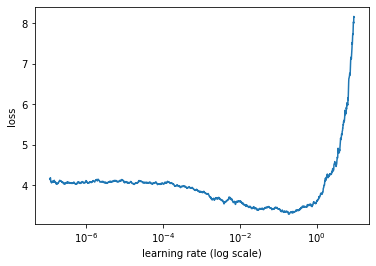

In [0]:
learner.lr_plot()

In [0]:
learner.autofit(0.2, 3)



begin training using triangular learning rate policy with max lr of 0.2...
Train on 140597 samples
Epoch 1/3
140597/140597 [==============================] - 175s 1ms/sample - loss: 3.3842 - acc: 0.1559
Epoch 2/3
140597/140597 [==============================] - 177s 1ms/sample - loss: 3.3445 - acc: 0.1574
Epoch 3/3
140597/140597 [==============================] - 176s 1ms/sample - loss: 3.3442 - acc: 0.1569


In [0]:
learner.validate(val_data=(x_test, y_test), class_names=list(cats))

                precision    recall  f1-score   support

         CRIME       0.00      0.00      0.00       814
 ENTERTAINMENT       0.00      0.00      0.00      3993
    WORLD NEWS       0.00      0.00      0.00       510
        IMPACT       0.00      0.00      0.00       853
      POLITICS       0.17      1.00      0.28      8305
    WEIRD NEWS       0.00      0.00      0.00       639
  BLACK VOICES       0.00      0.00      0.00      1163
         WOMEN       0.00      0.00      0.00       854
        COMEDY       0.00      0.00      0.00      1298
  QUEER VOICES       0.00      0.00      0.00      1616
        SPORTS       0.00      0.00      0.00      1253
      BUSINESS       0.00      0.00      0.00      1460
        TRAVEL       0.00      0.00      0.00      2474
         MEDIA       0.00      0.00      0.00       702
          TECH       0.00      0.00      0.00       511
      RELIGION       0.00      0.00      0.00       640
       SCIENCE       0.00      0.00      0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Using simpletransformers

In [0]:
!wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

In [0]:
!conda install -y -q pytorch cudatoolkit=10.0 -c pytorch

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [0]:
!sh setup.sh

In [0]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [0]:
train['text'] = train['text'].apply(lambda x: x.replace('\\', ' '))
test['text'] = test['text'].apply(lambda x: x.replace('\\', ' '))

In [0]:
model = ClassificationModel('albert', 'albert-base-v2', num_labels=len(cats),
                            args={'reprocess_input_data': True,
                                  'overwrite_output_dir': True,
                                  'fp16_opt_level': 'O1',
                                  'keep_batchnorm_fp32': None, 
                                  "output_dir": "/content/drive/My Drive/NewsBert/outputs/",
                                  "cache_dir": "/content/drive/My Drive/NewsBert/cache_dir/",
                                  "learning_rate": 2e-5,
                                  "num_train_epochs": 3,
                                  'max_seq_length': 300,
                                  'tensorboard_folder': "/content/drive/My Drive/NewsBert/run/"})

In [0]:
model.train_model(train)

In [0]:
reloaded_model = ClassificationModel('albert', '/content/drive/My Drive/NewsBert/outputs/', num_labels=len(cats),
                            args={'reprocess_input_data': True,
                                  'overwrite_output_dir': True,
                                  "output_dir": "/content/drive/My Drive/NewsBert/outputs/",
                                  "cache_dir": "/content/drive/My Drive/NewsBert/cache_dir/",
                                  "learning_rate": 5e-5,
                                  "num_train_epochs": 1,
                                  'max_seq_length': 300,
                                  'tensorboard_folder': "/content/drive/My Drive/NewsBert/run/"})

In [0]:
result, model_outputs, wrong_predictions = model.eval_model(test, acc=sk.metrics.accuracy_score)

Converting to features started.


In [0]:
result

{'acc': 0.7390301380775358,
 'eval_loss': 0.9445215776143274,
 'mcc': 0.7216599787269715}

In [0]:
train.head()

,text,label
158472,Facebook Activity Is Reflection Of U.S. Obesi...,29
22977,Kimberly Yam NY Assembly Passes Bill That Woul...,4
125976,"Leigh Merryday Porch, Contributor\nSpecial edu...",20
39640,"Nell Minow, ContributorMovie critic, corporate...",1
79809,"Bonnie Fuller, ContributorPresident & Editor-i...",18


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140597 entries, 158472 to 74752
Data columns (total 2 columns):
text     140597 non-null object
label    140597 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


In [0]:
ktrain.text.texts_from_array?